In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
)
import joblib

RANDOM_STATE = 42

In [2]:
pokemon = pd.read_csv("/Users/user/mai24ma/AI_theory/kunskapskontroll/grupp/dataset/pokemon.csv")
combats = pd.read_csv("/Users/user/mai24ma/AI_theory/kunskapskontroll/grupp/dataset/combats.csv")

In [3]:
pokemon["Name"] = pokemon["Name"].astype(str)
pokemon.loc[pokemon["Name"].str.strip().isin(["", "nan", "NaN"]), "Name"] = np.nan

missing_names = {
    63: "Primeape"
}

pokemon["Name"] = pokemon.apply(
    lambda r: missing_names.get(r["#"], r["Name"]),
    axis=1
)

In [4]:
expected_columns = {
    "#", "Name", "Type 1", "Type 2",
    "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed",
    "Generation", "Legendary",
}
missing = expected_columns - set(pokemon.columns)
if missing:
    raise ValueError(f"Missing columns in the dataset: {missing}")

In [5]:
# Rensa pokemon-tabell (ID, datatyper)

pokemon_full = pokemon.rename(columns={"#": "pokemon_id"}).copy()

pokemon_full["Name"] = pokemon_full["Name"].astype(str).fillna("")

if pokemon_full["Legendary"].dtype == bool:
    pokemon_full["Legendary"] = pokemon_full["Legendary"].astype(int)
else:
    pokemon_full["Legendary"] = (
        pokemon_full["Legendary"].astype(str).str.lower().map({"true": 1, "false": 0}).fillna(0).astype(int)
    )

for col in ["Type 1", "Type 2"]:
    pokemon_full[col] = (
        pokemon_full[col]
        .astype(str)
        .str.strip()
        .replace({"": np.nan, "nan": np.nan})
        .fillna("None")
    )

stats_cols = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed", "Generation", "Legendary"]

pokemon_min = pokemon_full[["pokemon_id"] + stats_cols].copy()

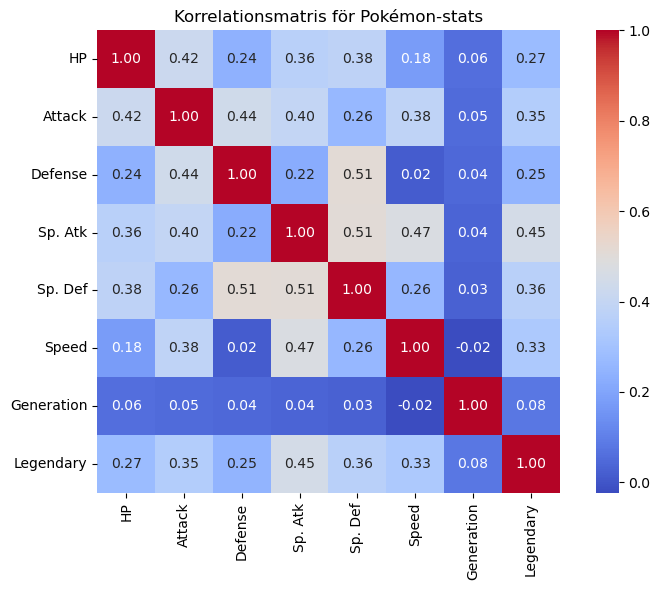

In [6]:
plt.figure(figsize=(8,6))
corr = pokemon_full[stats_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Korrelationsmatris för Pokémon-stats")
plt.tight_layout()
plt.show()

In [7]:
# Sammanslagen strids-tabell + target

df = combats.merge(
    pokemon_min.add_prefix("P1_"),
    left_on="First_pokemon", right_on="P1_pokemon_id", how="left"
).merge(
    pokemon_min.add_prefix("P2_"),
    left_on="Second_pokemon", right_on="P2_pokemon_id", how="left"
)

# Target: 1 om P1 vinner, annars 0
df["y"] = (df["Winner"] == df["First_pokemon"]).astype(int)

# Ta bort dubblettparet
pairs = pd.DataFrame({
    "a": np.minimum(df["P1_pokemon_id"], df["P2_pokemon_id"]),
    "b": np.maximum(df["P1_pokemon_id"], df["P2_pokemon_id"]),
})
df["pair_key"] = pairs["a"].astype(str) + "_" + pairs["b"].astype(str)
df = df.drop_duplicates(subset="pair_key", keep="first").reset_index(drop=True)

In [8]:
# Lägg till typer (P1/P2) och One-Hot-Encoda

types = pokemon_full[["pokemon_id", "Type 1", "Type 2"]].copy()

df = df.merge(types.add_prefix("P1_"), left_on="P1_pokemon_id", right_on="P1_pokemon_id", how="left")
df = df.merge(types.add_prefix("P2_"), left_on="P2_pokemon_id", right_on="P2_pokemon_id", how="left")

# Kör "None" igen för att säkra upp
for col in ["P1_Type 1", "P1_Type 2", "P2_Type 1", "P2_Type 2"]:
    df[col] = (
        df[col]
        .astype(str).str.strip()
        .replace({"": np.nan, "nan": np.nan})
        .fillna("None")
    )

type_dummies = pd.get_dummies(
    df[["P1_Type 1", "P1_Type 2", "P2_Type 1", "P2_Type 2"]],
    prefix=["P1_T1", "P1_T2", "P2_T1", "P2_T2"]
)

In [9]:
# Feature engineering (diffar mellan P1 och P2)

diff_cols = []
for c in stats_cols:
    df[f"diff_{c}"] = df[f"P1_{c}"] - df[f"P2_{c}"]
    diff_cols.append(f"diff_{c}")

X_num = df[diff_cols].copy()
X = pd.concat([X_num, type_dummies], axis=1)
y = df["y"].copy()

bad_cols = {"First_pokemon", "Second_pokemon", "Winner", "P1_pokemon_id", "P2_pokemon_id", "pair_key"}
assert not any(c in X.columns for c in bad_cols), "ID-liknande kolumner smög in i X"

print("Klassfördelning (0=P2 vinner, 1=P1 vinner):")
print(y.value_counts(normalize=True).rename({0: "P2_wins", 1: "P1_wins"}))
p1_rate = y.mean()
print(f"Naiv baseline (alltid gissa majoriteten): {max(p1_rate, 1 - p1_rate):.3f}\n")

Klassfördelning (0=P2 vinner, 1=P1 vinner):
y
P2_wins    0.528815
P1_wins    0.471185
Name: proportion, dtype: float64
Naiv baseline (alltid gissa majoriteten): 0.529



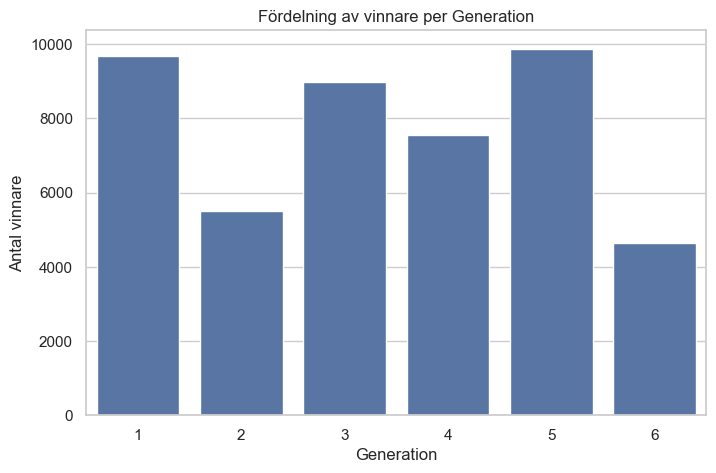

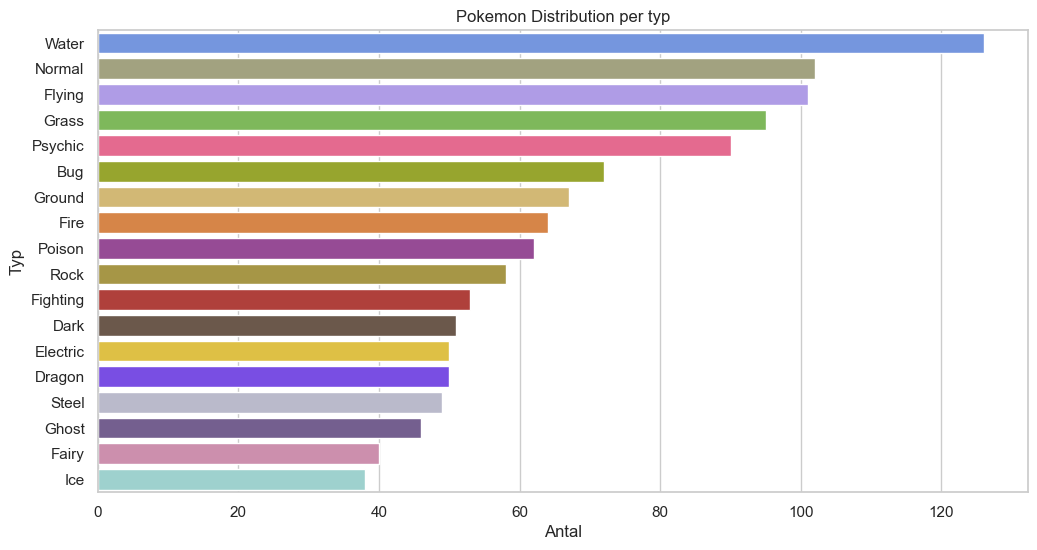

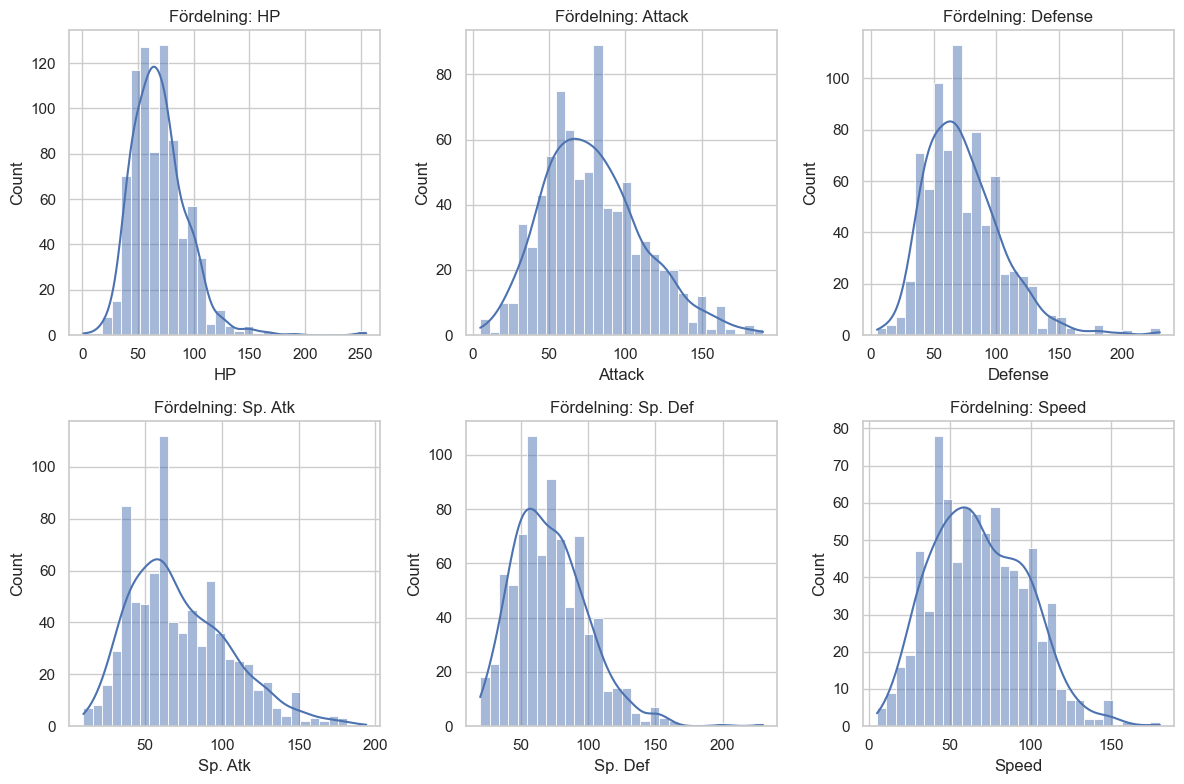

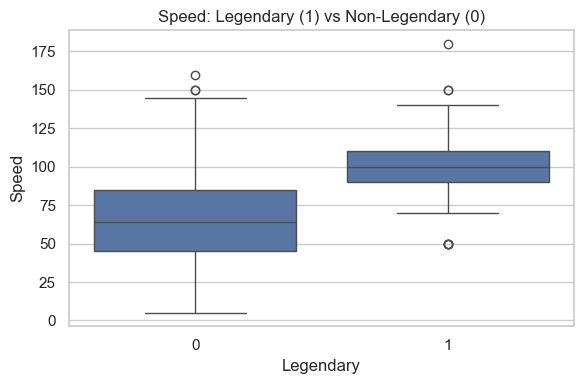

In [10]:
# =============================================================================
# EDA / Visualiseringar
# =============================================================================
sns.set(style="whitegrid")

# Färgkarta för typer (from Epidemic Johto / standardfärger)
TYPE_COLORS = {
    "Normal":   "#A8A77A",
    "Fire":     "#EE8130",
    "Water":    "#6390F0",
    "Electric": "#F7D02C",
    "Grass":    "#7AC74C",
    "Ice":      "#96D9D6",
    "Fighting": "#C22E28",
    "Poison":   "#A33EA1",
    "Ground":   "#E2BF65",
    "Flying":   "#A98FF3",
    "Psychic":  "#F95587",
    "Bug":      "#A6B91A",
    "Rock":     "#B6A136",
    "Ghost":    "#735797",
    "Dragon":   "#6F35FC",
    "Dark":     "#705746",
    "Steel":    "#B7B7CE",
    "Fairy":    "#D685AD",
    "None":     "#9AA0A6"
}

def type_palette(categories):
    """Returnera en lista med hex-färger i samma ordning som kategorierna."""
    return [TYPE_COLORS.get(str(t), "#999999") for t in categories]


# -----------------------------
# Vinnare per generation
# -----------------------------
winners = df.merge(
    pokemon_full[["pokemon_id", "Generation", "Type 1", "Type 2"]],
    left_on="Winner", right_on="pokemon_id", how="left"
)

plt.figure(figsize=(8, 5))
sns.countplot(data=winners, x="Generation", color="#4C72B0")
plt.title("Fördelning av vinnare per Generation")
plt.xlabel("Generation")
plt.ylabel("Antal vinnare")
plt.show()

type_counts = (
    pd.concat([pokemon_full["Type 1"], pokemon_full["Type 2"].replace({"None": np.nan})])
      .dropna()
      .value_counts()
)
order_all = type_counts.index
plt.figure(figsize=(12, 6))
sns.barplot(
    y=order_all,
    x=type_counts.values,
    hue=order_all,
    dodge=False,
    palette=TYPE_COLORS,
    legend=False
)
plt.title("Pokemon Distribution per typ")
plt.xlabel("Antal")
plt.ylabel("Typ")
plt.show()

# Histogram över några centrala stats
fig, axes = plt.subplots(2, 3, figsize=(12,8))
cols = ["HP","Attack","Defense","Sp. Atk","Sp. Def","Speed"]
for ax, c in zip(axes.ravel(), cols):
    sns.histplot(pokemon_full[c], bins=30, ax=ax, kde=True)
    ax.set_title(f"Fördelning: {c}")
plt.tight_layout()
plt.show()

# Boxplot: Legendary vs icke-Legendary för Speed (byt kolumn om du vill)
plt.figure(figsize=(6,4))
sns.boxplot(data=pokemon_full, x="Legendary", y="Speed")
plt.title("Speed: Legendary (1) vs Non-Legendary (0)")
plt.xlabel("Legendary")
plt.ylabel("Speed")
plt.tight_layout()
plt.show()

In [11]:
# Träning: Train/Test-split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)


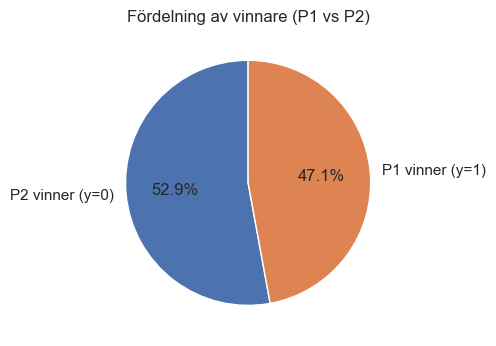

In [12]:
plt.figure(figsize=(5,5))
labels = ["P2 vinner (y=0)", "P1 vinner (y=1)"]
sizes = [ (y==0).mean(), (y==1).mean() ]
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Fördelning av vinnare (P1 vs P2)")
plt.tight_layout()
plt.show()

In [13]:
# Baseline: Logistic Regression (med scaling)

lr_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)), 
    ("clf", LogisticRegression(
        max_iter=300,
        solver="lbfgs",
        class_weight="balanced",
        n_jobs=None,
        random_state=RANDOM_STATE
    ))
])

lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=300,
                                    random_state=42))])

LR Test Accuracy: 0.884
LR F1 macro: 0.8838383838383839

Classification report (LR):
              precision    recall  f1-score   support

     P2_wins      0.901     0.877     0.889      4889
     P1_wins      0.866     0.892     0.879      4357

    accuracy                          0.884      9246
   macro avg      0.884     0.884     0.884      9246
weighted avg      0.885     0.884     0.884      9246



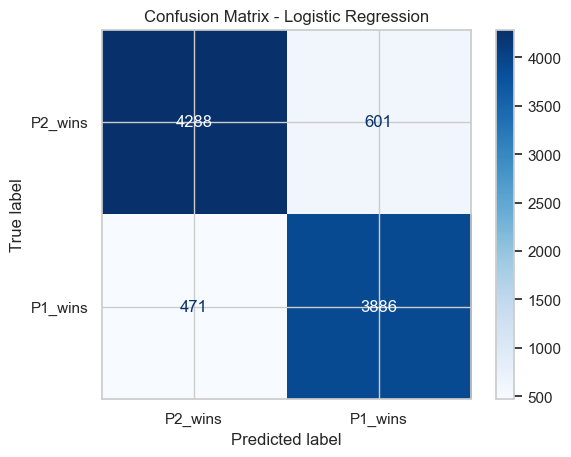

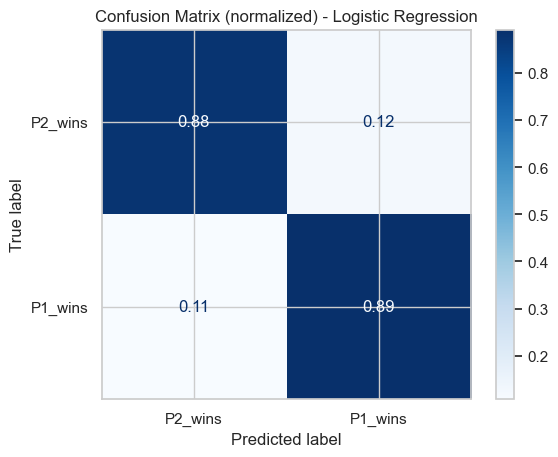

LR CV Accuracy (mean ± std): 0.888 ± 0.003

Top 10 features som gynnar P1 (LR):
diff_Speed         2.777187
diff_Attack        0.497563
diff_Generation    0.113504
P1_T1_Dark         0.084825
P1_T2_Flying       0.075393
diff_HP            0.072529
diff_Sp. Def       0.068738
P1_T1_Ground       0.064095
P2_T1_Dragon       0.063733
P1_T1_Fire         0.058557
dtype: float64

Top 10 features som gynnar P2 (LR):
P2_T1_Dark       -0.057624
P1_T1_Dragon     -0.061664
P1_T1_Ghost      -0.062732
diff_Legendary   -0.069827
P1_T1_Psychic    -0.071215
P2_T1_Normal     -0.073561
P2_T1_Ghost      -0.090046
P2_T2_Steel      -0.100148
P1_T2_Ghost      -0.228473
P2_T2_Ghost      -0.313106
dtype: float64


In [14]:
# Utvärdering

y_pred = lr_pipe.predict(X_test)
print(f"LR Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("LR F1 macro:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification report (LR):")
print(classification_report(y_test, y_pred, digits=3, target_names=["P2_wins", "P1_wins"]))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["P2_wins", "P1_wins"], cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["P2_wins", "P1_wins"], cmap="Blues", normalize="true")
plt.title("Confusion Matrix (normalized) - Logistic Regression")
plt.show()

cv_scores = cross_val_score(lr_pipe, X, y, cv=5, n_jobs=-1)
print(f"LR CV Accuracy (mean ± std): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

clf = lr_pipe.named_steps["clf"]
coef_s = pd.Series(clf.coef_[0], index=X.columns).sort_values(ascending=False)
print("\nTop 10 features som gynnar P1 (LR):")
print(coef_s.head(10))
print("\nTop 10 features som gynnar P2 (LR):")
print(coef_s.tail(10))


RF Test Accuracy: 0.957
RF F1 macro: 0.957


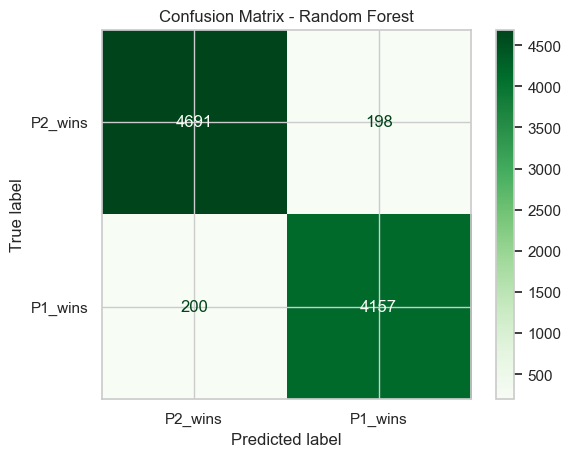


Top 10 feature importances (RF):
diff_Speed         0.638862
diff_Attack        0.061969
diff_Sp. Atk       0.050872
diff_HP            0.032031
diff_Sp. Def       0.030039
diff_Defense       0.025710
diff_Generation    0.014321
diff_Legendary     0.009927
P1_T2_Flying       0.007060
P2_T2_Ghost        0.006661
dtype: float64


In [15]:
# Random Forest

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    class_weight="balanced_subsample",
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRF Test Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print("RF F1 macro:", round(f1_score(y_test, y_pred_rf, average="macro"), 3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=["P2_wins", "P1_wins"], cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.show()

rf_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 feature importances (RF):")
print(rf_imp.head(10))

<Figure size 700x400 with 0 Axes>

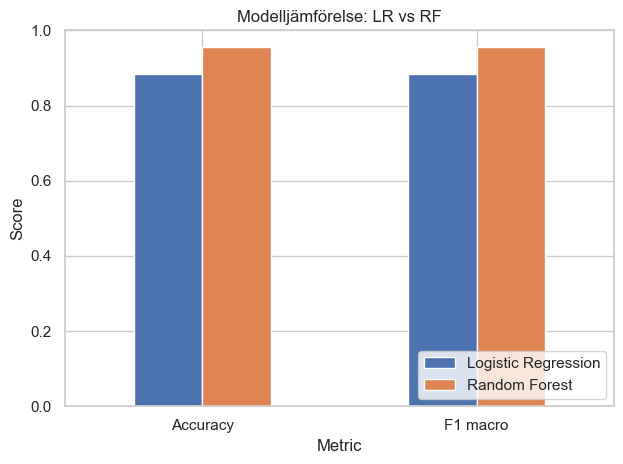

In [16]:
met_names = ["Accuracy", "F1 macro"]
lr_vals = [accuracy_score(y_test, lr_pipe.predict(X_test)),
           f1_score(y_test, lr_pipe.predict(X_test), average="macro")]
rf_vals = [accuracy_score(y_test, rf.predict(X_test)),
           f1_score(y_test, rf.predict(X_test), average="macro")]

plot_df = pd.DataFrame({
    "Metric": met_names,
    "Logistic Regression": lr_vals,
    "Random Forest": rf_vals
})

plt.figure(figsize=(7,4))
plot_df.set_index("Metric").plot(kind="bar")
plt.ylim(0,1)
plt.title("Modelljämförelse: LR vs RF")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [17]:
# Hyperparametrering av LR

grid = GridSearchCV(
    lr_pipe,
    {"clf__C": [0.1, 1.0, 3.0]},
    cv=5, n_jobs=-1
)
grid.fit(X_train, y_train)
print("Bästa C:", grid.best_params_, "CV-acc:", round(grid.best_score_, 3))

Bästa C: {'clf__C': 3.0} CV-acc: 0.888


In [18]:
# Spara för streamlit

joblib.dump(lr_pipe, "pokemon_battle_lr.pkl")
joblib.dump(rf, "pokemon_battle_rf.pkl")
joblib.dump(list(X.columns), "feature_columns.pkl")
print("\nSparade modeller: pokemon_battle_lr.pkl, pokemon_battle_rf.pkl")
print("Saved feature_columns.pkl")


Sparade modeller: pokemon_battle_lr.pkl, pokemon_battle_rf.pkl
Saved feature_columns.pkl
